# 0.2 Running a Basic Model on Combigen

In this notebook we're going to just run the combigen task designed in nb 0.1 on some more modern models.

## Jupyter Extensions

Load [watermark](https://github.com/rasbt/watermark) to see the state of the machine and environment that's running the notebook. To make sense of the options, take a look at the [usage](https://github.com/rasbt/watermark#usage) section of the readme.

In [1]:
# Load `watermark` extension
%load_ext watermark
# Display the status of the machine and packages. Add more as necessary.
%watermark -v -n -m -g -b -t -p numpy,matplotlib,seaborn,tensorflow,keras

Sun Feb 17 2019 01:05:50 

CPython 3.6.8
IPython 7.2.0

numpy 1.15.4
matplotlib 3.0.2
seaborn 0.9.0
tensorflow 1.10.0
keras 2.2.4

compiler   : GCC 7.3.0
system     : Linux
release    : 4.15.0-45-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit
Git hash   : 004dfcf92461e28b894964312ee85c596fb8363c
Git branch : master


Using TensorFlow backend.


Load [autoreload](https://ipython.org/ipython-doc/3/config/extensions/autoreload.html) which will always reload modules marked with `%aimport`.

This behavior can be inverted by running `autoreload 2` which will set everything to be auto-reloaded *except* for modules marked with `%aimport`.

In [2]:
# Load `autoreload` extension
%load_ext autoreload
# Set autoreload behavior
%autoreload 1

Load `matplotlib` in one of the more `jupyter`-friendly [rich-output modes](https://ipython.readthedocs.io/en/stable/interactive/plotting.html). Some options (that may or may not have worked) are `inline`, `notebook`, and `gtk`.

In [3]:
# Set the matplotlib mode
%matplotlib inline

## Imports

Static imports that shouldn't necessarily change throughout the notebook.

In [4]:
# Standard library imports
import logging

# Third party
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

Local imports that may or may not be autoreloaded. This section contains things that will likely have to be re-imported multiple times, and have additions or subtractions made throughout the project.

In [62]:
# Task script
%aimport leabratf.tasks.combinatorics.combigen
import leabratf.tasks.combinatorics.combigen as cbg
# Visualization for the task
%aimport leabratf.visualization.combigen_heatmap
import leabratf.visualization.combigen_heatmap as cbhm
# Utility functions
%aimport leabratf.utils
from leabratf.utils import setup_logging

## Initial Setup

Set [seaborn defaults](https://seaborn.pydata.org/generated/seaborn.set.html) for matplotlib.

In [6]:
sns.set()

Set up the logger configuration to something more useful than baseline. Creates log files for the different log levels in the `logs` directory.

See `logging.yml` for the exact logging configuration.

In [7]:
# Run base logger setup
setup_logging()
# Define a logger object
logger = logging.getLogger("leabratf")

## The Combigen Task

Now that the task has been put together from nb 0.1, let's import the functionified version of it and start prepping for running the model.

First let's refresh our memory on the task.

2019-02-15 17:42:41 apra-xps13 leabratf.utils[20843] WARNING First argument passed is not of type `np.ndarray`. Skipping reshape operation.
2019-02-15 17:42:41 apra-xps13 leabratf.utils[20843] WARNING First argument passed is not of type `np.ndarray`. Skipping reshape operation.
2019-02-15 17:42:41 apra-xps13 leabratf.utils[20843] WARNING First argument passed is not of type `np.ndarray`. Skipping reshape operation.
2019-02-15 17:42:41 apra-xps13 leabratf.utils[20843] WARNING First argument passed is not of type `np.ndarray`. Skipping reshape operation.


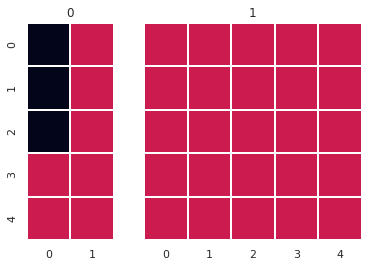

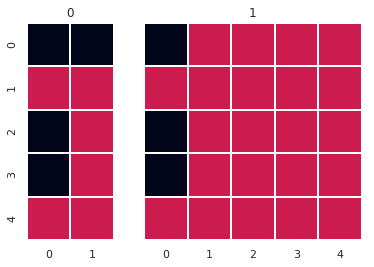

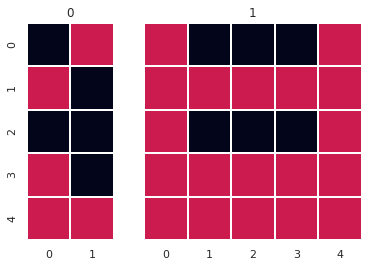

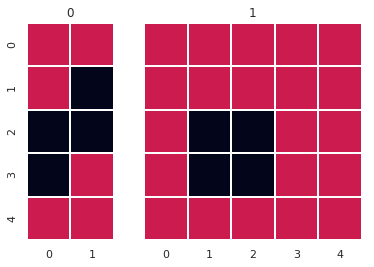

In [45]:
# Visulize a few combinations of x and y
for _ in range(4):
    # Generate a signle y
    example_y = cbg.generate_labels()
    # Generate a single x from the y
    example_x = cbg.inverse_transform(example_y)
    cbhm.heatmap([example_y, example_x[0]], gridspec_kw={'width_ratios': [2, 5]}, sharex=False)
plt.show()

Just by luck, I spotted a corner case for the task that would make it impossible to classify, which is the situation where one of the columns in the label is completely on. This will need to be remedied first before continuing with the notebook.

If this is not present in the notebook at the time of viewing that is either because it hasn't out of chance or I've already made the change to the repo.

## Combigen Fix

It is currently defined as the following:

```
def generate_labels(n_samples=1, size=5, dims=2):
    """..."""
    return np.random.choice(2, (n_samples, size, dims), True)
```

So let's tweak it so it ensures that one of the indices are zero.

In [126]:
def generate_labels(n_samples=1, size=5, dims=2):
    """Returns an array of labels to construct the data from.

    Parameters
    ----------
    n_samples : int, optional
    	Number of samples to return.

    size : int, optional
    	Size of the nxn matrix to use for the task.

    dims : int, optional
    	Number of dimensions for the task.

    Returns
    -------
    labels : np.ndarray (n_samples x size x dims)
    	The resulting task labels.
    """
    # Generate baseline labels
    raw_labels = np.random.choice(2, (n_samples, size, dims), replace=True)
    # Random selection of indices to zero out
    arg_zero = np.random.choice(size, (n_samples*dims), replace=True)
    # Alternating indices to loop through the dims of the labels
    dim_indices = np.tile(range(dims), n_samples)
    # Repeating indices to loop through the samples
    sample_indices = np.repeat(range(n_samples), dims)
    
    # Zero out a random selection of indices
    raw_labels[sample_indices, arg_zero, dim_indices] = 0
    return raw_labels

And now let's just visually inspect a sampling of `y`s to see if it ever happens.

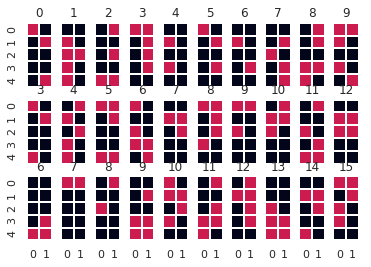

In [130]:
# Visualize a bunch of y values
cbhm.heatmap(generate_labels(30))

Looks good so far, let's try being systematic.

In [145]:
# Generate a large number of y values to test
large_test_Y = generate_labels(1000000)

# Sum over the long dimension of each sample to see how many of them are set to
# the on state. If they are all on, then it will sum to the length of the dim.
values_in_sum = np.isin(range(large_test_Y.shape[1] + 1), np.sum(large_test_Y, axis=1))
# We should see that all values up to the last one are set to True
for i, present in enumerate(values_in_sum):
    print('"{0}" present in sum: {1}'.format(i, present))
    
# Delete large_test_Y just because of how large it is
del large_test_Y

"0" present in sum: True
"1" present in sum: True
"2" present in sum: True
"3" present in sum: True
"4" present in sum: True
"5" present in sum: False


Now that it works as expected, lets move back to setting up the data.

## O'Reily BP Model

Before working with anything close to state of the art (SOTA), a good place to start is with the backpropagation model that O'Reily used in his paper. It's described as a fully connected network with 100 hidden units, so let's put all that into a hyper-parameter variable.

Note: Instead of dictionaries to hold config-type data, I'm using `pdict`s from the [pstar](https://github.com/iansf/pstar) repo as mentioned in ([this](https://danijar.com/patterns-for-fast-prototyping-with-tensorflow/) blog post.

In [32]:
# pdicts allow for attribute dictionary setting among other things
from pstar import pdict
# for the checkpoint path
from leabratf.constants import DIR_MODELS

hyper_params = pdict()

# Task parameters - see the 0.1 for the experimental design
hyper_params.combigen_dims = 2
hyper_params.combigen_size = 5
# Stack number is currently not implemented, but will be for future analyses
# hyper_params.combigen_stack = 4
hyper_params.n_train = 100
hyper_params.n_test = 10000

# Network parameters - see paper description
hyper_params.layer_size = 100
hyper_params.output_size = hyper_params[['combigen_size', 'combigen_dims']]

# Training parameters
hyper_params.learning_rate = 0.001
hyper_params.batch_size = 1 
hyper_params.epochs = 100

# Experiment Parameters
hyper_params.save_weights = True
hyper_params.validation_iters = 1000

hyper_params.checkpoint_path = str(DIR_MODELS / 'checkpoints')

Let's put together the dataset object that will be fed into the model. First generate the master list of data to be used for training and testing.

In [72]:
y = cbg.generate_labels(
    n_samples = hyper_params.n_train + hyper_params.n_test,
    size = hyper_params.combigen_size,
    dims = hyper_params.combigen_dims)
X = cbg.inverse_transform(y)
# Quick sanity check
assert x.shape[0] == y.shape[0]

# Lets print some quick info
print('Shape y: {0} \nShape X: {1}'.format(y.shape, X.shape))

Shape y: (1100, 5, 2) 
Shape X: (1100, 5, 5)


And then let's put it in a `dataset` object.

In [85]:
# Define the dataset
dataset = tf.data.Dataset.from_tensor_slices((X, y))
dataset = dataset.batch(hyper_params.batch_size)
# Define the iterator and next element
iterator = dataset.make_one_shot_iterator()
next_element = iterator.get_next()

And to make sure everything is as expected.

In [86]:
with tf.Session() as sess:
    print(sess.run(next_element))

(array([[[False,  True, False, False,  True],
        [False,  True, False, False,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [False,  True, False, False,  True]]]), array([[[0, 0],
        [0, 1],
        [1, 0],
        [1, 0],
        [0, 1]]]))


Now we can start putting together the model.

In [24]:
def create_model_obp(input_tensor, mode, hyper_params):
    """Function that generates the the O'Reily backpropagation model."""
    model = pdict()
    with tf.variable_scope("OBPDenseNet") as scope:
        # Reuse the weights if we're evaling
        if mode == tf.estimator.ModeKeys.EVAL:`
            scope.reuse_variables()
        # Reshape the data accordingly
        x = tf.reshape(tensor=input_tensor, shape=[-1, *hyper_params.output_size], name='input')
        # Single hidden layer
        model.logits = tf.layers.dense(x, units=hyper_params.layer_size)
        model.probs = tf.nn.softmax(logits=model.logits, name='probs')
    return model

Next the loss.

In [29]:
def create_loss(model, labels, mode, hyper_params):
    """Function that returns the loss of a model on the labels."""
    metrics = pdict()
    
    y = tf.reshape(labels, [-1, *hyper_params.output_size], name='labels')
    loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
        logits=model.logits,
        labels=y,
    ))
    loss_name = str(mode) + '/loss'
    tf.summary.scalar(loss_name, loss_op)
    metrics.loss_name = loss_op
    
    return loss_op, metrics

Now put them together along with an optimizer to create `model_fn`

In [88]:
def model_fn(features, labels, mode, hyper_params):
    # Create the model
    model = create_model_obp(features, mode, hyper_params)
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=model)
    
    # Loss
    loss, metrics = create_loss(model, labels, mode, hyper_params)
    if mode == tf.estimator.ModeKeys.EVAL:
        return tf.estimator.EstimatorSpec(mode, loss=loss, eval_metric_ops=metrics)
    
    # Optimizer
    if mode == tf.estimator.ModeKeys.TRAIN:
        train_op = tf.train.GradientDescentOptimizer(
            learning_rate=hyper_params.learning_rate).minimize(loss)
    
    raise RuntimeError('Invalid mode entered, {})'.format(mode))

In [96]:


estimator = tf.estimator.Estimator(model_fn, hyper_params=hyper_params)
                                   

TypeError: __init__() got an unexpected keyword argument 'hyper_params'


So let's just confirm that `tensorflow` is happy with the function.

## Hints

Various hints for working on `jupyter notebooks`. Should probably be removed when a notebook is completed.

General stuff:
- To make logging even lazier, set `print = logger.info`, and then `print` away!
- The `!` can be used to run shell commands from within the notebook (ex. `!which conda`)
- Use `assert` liberally - this isn't a script and it's very readable.

Cheatsheets:
- [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet)